In [1]:
import pandas as pd
import numpy as np
import math
from numpy import sqrt, radians, arcsin, sin, cos
import matplotlib.pyplot as plt

from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import Polygon


In [2]:
class GeospatialPoint():
    # initialise
    def __init__(self, x=None, y=None):
        self.x = x
        self.y = y
    
    # representation
    def __repr__(self):
        return f'Point(x={self.x:.2f}, y={self.y:.2f})'

        # Test for equality between Points
    def __eq__(self, other): 
        if not isinstance(other, Point):
            # don't attempt to compare against unrelated types
            return NotImplemented
        return self.x == other.x and self.y == other.y

    # We need this method so that the class will behave sensibly in sets and dictionaries
    def __hash__(self):
        return hash((self.x, self.y))
    
    # calculate Euclidean distance between two points
    def distEuclidean(self, other):
        return sqrt((self.x-other.x)**2 + (self.y-other.y)**2)
    
    # calculate Manhattan distance between two points
    def distManhattan(self, other):
        return abs(self.x-other.x) + abs(self.y-other.y)

    # Haversine distance between two points on a sphere - requires lat/lng converted to radians
    def distHaversine(self, other):
        r = 6371000  # Earth's radius in metres (will return result in metres)
        phi1 = radians(self.y) # latitudes
        phi2 = radians(other.y)
        lam1 = radians(self.x) # longitudes
        lam2 = radians(other.x)

        d = 2 * r * arcsin(sqrt(sin((phi2 - phi1)/2)**2 + 
                                      cos(phi1) * cos(phi2) * sin((lam2 - lam1)/2)**2))
        return d   

    
    # Calculate determinant with respect to three points. Note the order matters here - we use it to work out left/ right in the next method
    def __det(self, p1, p2):
        det = (self.x-p1.x)*(p2.y-p1.y)-(p2.x-p1.x)*(self.y-p1.y)       
        return det

    def leftRight(self, p1, p2):
        # based on GIS Algorithms, Ch2, p11-12, by Ningchuan Xiao, publ. 2016
        # -ve: this point is on the left side of a line connecting p1 and p2
        #   0: this point is collinear
        # +ve: this point is on the right side of the line
        side = int(self.__det(p1, p2))
        if side != 0:
            side = side/abs(side)  # will return 0 if collinear, -1 for left, 1 for right
        return side

In [3]:
def buffer_points(points, buffer_size):
    """
    Buffer points with buffer size.
    
    inputs
      - points: list of tuples, each containing x and y coordinates
      - buffer_size: float, the size of the buffer radius
      
    output
      - list of points
    """
    buffered_points = []
    for point in points:
        x = point.x
        y = point.y
        
        # Create a circle of points around the original point
        angles = np.linspace(0, (2-2/50)*np.pi, num=10)
        circle_points = [shapely.Point(x + buffer_size*np.cos(a), y + buffer_size*np.sin(a)) for a in angles]
        
        buffered_points += circle_points
    
    return buffered_points

In [4]:
class ConcaveHull(object):

    def __init__(self, points, k):
        if isinstance(points, np.core.ndarray):
            self.data_set = points
        elif isinstance(points, list):
            self.data_set = np.array(points)
        else:
            raise ValueError('Please provide an [N,2] numpy array or a list of lists.')

        # Clean up duplicates
        self.data_set = np.unique(self.data_set, axis=0)

        # Create the initial index
        self.indices = np.ones(self.data_set.shape[0], dtype=bool)  # bool of a column of all 1's

        self.k = k

    @staticmethod
    def dist_pt_to_group(a, b):  # a is a (n,2) , b is (1,2) arrays
        d = np.sqrt(np.sum(np.square(np.subtract(a, b)), axis=1))
        return d

    @staticmethod
    def get_lowest_latitude_index(points):
        indices = np.argsort(points[:, 1])
        return indices[0]

    @staticmethod
    def norm_array(v):  # normalize row vectors in an array. observations are rows
        norms = np.array(np.sqrt(np.sum(np.square(v), axis=1)), ndmin=2).transpose()
        return np.divide(v, norms)

    @staticmethod
    def norm(v):  # normalize a single vector, is there an existing command?
        norms = np.array(np.sqrt(np.sum(np.square(v))))
        return v / norms

    def get_k_nearest(self, ix, k):
        """
        Calculates the k nearest point indices to the point indexed by ix
        :param ix: Index of the starting point
        :param k: Number of neighbors to consider
        :return: Array of indices into the data set array
        """
        ixs = self.indices
        # base_indices is list of linear indicies that are TRUE, ie part of dataset
        base_indices = np.arange(len(ixs))[ixs]
        distances = self.dist_pt_to_group(self.data_set[ixs, :], self.data_set[ix, :])
        sorted_indices = np.argsort(distances)

        kk = min(k, len(sorted_indices))
        k_nearest = sorted_indices[range(kk)]
        return base_indices[k_nearest]

    def clockwise_angles(self, last, ix, ixs, first):  # last needs to be the index of the previous current point
        if first == 1:
            last_norm = np.array([-1, 0], ndmin=2)
        elif first == 0:
            last_norm = self.norm(np.subtract(self.data_set[last, :], self.data_set[ix,:]))  # normalized vector pointing towards previous point
        ixs_norm = self.norm_array(np.subtract(self.data_set[ixs, :], self.data_set[ix,:]))  # normalized row vectors pointing to set of k nearest neibs
        ang = np.zeros((ixs.shape[0], 1))
        for j in range(ixs.shape[0]):
            theta = np.arccos(np.dot(last_norm, ixs_norm[j, :]))
            # ang[j,0] = theta
            z_comp = np.cross(last_norm, ixs_norm[j, :])
            # ang[j,2] = z
            if z_comp <= 0:
                ang[j, 0] = theta
            elif z_comp > 0:
                ang[j, 0] = 2 * np.pi - theta
        return np.squeeze(ang)

    def recurse_calculate(self):
        """
        Calculates the concave hull using the next value for k while reusing the distances dictionary
        :return: Concave hull
        """
        recurse = ConcaveHull(self.data_set, self.k + 1)
        if recurse.k >= self.data_set.shape[0]:
            print(" max k reached, at k={0}".format(recurse.k))
            return None
        print("k={0}".format(recurse.k))
        return recurse.calculate()

    def calculate(self):
        """
        Calculates the convex hull of the data set as an array of points
        :return: Array of points (N, 2) with the concave hull of the data set
        """
        if self.data_set.shape[0] < 3:
            return None

        if self.data_set.shape[0] == 3:
            return self.data_set

        # Make sure that k neighbors can be found
        kk = min(self.k, self.data_set.shape[0])

        first_point = self.get_lowest_latitude_index(self.data_set)
        current_point = first_point
        # last_point = current_point # not sure if this is necessary since it wont get used until after step 2

        # Note that hull and test_hull are matrices (N, 2)
        hull = np.reshape(np.array(self.data_set[first_point, :]), (1, 2))
        test_hull = hull

        # Remove the first point
        self.indices[first_point] = False

        step = 2
        stop = 2 + kk

        while ((current_point != first_point) or (step == 2)) and len(self.indices[self.indices]) > 0:  # last condition counts number of ones, points in dataset
            if step == stop:
                self.indices[first_point] = True
            # notice how get_k_nearest doesnt take the data set directly as an arg, as it is implicit that it takes self as an imput because we are inside a class:
            knn = self.get_k_nearest(current_point, kk)  # knn = [3,6,2] or [0,2,7] etc indicies into the full dataset (with no points removed)

            if step == 2:
                angles = self.clockwise_angles(1, current_point, knn, 1)
            else:
                # Calculates the headings between first_point and the knn points
                # Returns angles in the same indexing sequence as in knn
                angles = self.clockwise_angles(last_point, current_point, knn, 0)

            # Calculate the candidate indexes (largest angles first). candidates =[0,1,2]  or [2,1,0] etc if kk=3
            candidates = np.argsort(-angles)

            i = 0
            invalid_hull = True

            while invalid_hull and i < len(candidates):
                candidate = candidates[i]

                # Create a test hull to check if there are any self-intersections
                next_point = np.reshape(self.data_set[knn[candidate], :], (1, 2))
                test_hull = np.append(hull, next_point, axis=0)

                line = shapely.LineString(test_hull)
                invalid_hull = not line.is_simple  # invalid_hull will remain True for every candidate which creates a line that intersects the hull. as soon as the hull doesnt self intersect, it will become false and the loop will terminate
                i += 1

            if invalid_hull:
                print("invalid hull for all nearest neibs")
                return self.recurse_calculate()

            last_point = current_point  # record last point for clockwise angles
            current_point = knn[candidate] # candidate = 0, 1, or 2 if kk=3
            hull = test_hull

            self.indices[current_point] = False # we remove the newly found current point from the "mask" indicies so that it wont be passed to get_k_nearest (within the implicit input, self)
            step += 1

        poly = shapely.Polygon(hull)

        count = 0
        total = self.data_set.shape[0]
        for ix in range(total):
            pt = shapely.Point(self.data_set[ix, :])
            if poly.intersects(pt) or pt.within(poly):
                count += 1
            else:
                print("point not in polygon")

        if count == total:
            return hull
        else:
            return self.recurse_calculate()


Application of Buffer to a self-drawn highway:

In [5]:
#Loading sample data from disk and turning it into a (n, 2)-array
myHighway = pd.read_csv("data/MyHighway_20230525_nnitsi.csv")

In [7]:
#Turn entries of dataframe into point objects and add to list
highway_nodes = []
for index, row in myHighway.iterrows():
    obj = geospatial.Point(row['x'], row['y'])
    highway_nodes.append(obj)
    
print(highway_nodes[0].x, ", ", highway_nodes[0].y)

2711900.026 ,  1263199.444


In [35]:
#Create buffer points around each node with a distance of 10m
node_buffer = buffer_points(highway_nodes, 1000)

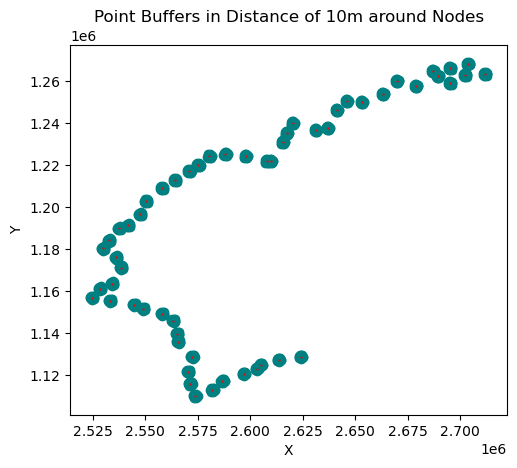

In [36]:
#Visualizing buffer points
xs = [i.x for i in node_buffer]
ys = [i.y for i in node_buffer]

fig, ax0 = plt.subplots()

ax0.scatter(xs, ys, color='teal')
ax0.scatter([point.x for point in highway_nodes], [point.y for point in highway_nodes], color = 'red', s=0.3)

ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.set_title('Point Buffers in Distance of 10m around Nodes')
ax0.set_aspect('equal')

In [37]:
#Create a list of lists as input into the buffer algorithm
node_buffer_list = [[node.x, node.y] for node in node_buffer]

In [38]:
hull_object = ConcaveHull(node_buffer_list,3)
hull = hull_object.calculate()

invalid hull for all nearest neibs
k=4
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in polygon
point not in pol

In [39]:
xs = [elem[0] for elem in node_buffer_list]
ys = [elem[1] for elem in node_buffer_list]

Text(0.5, 1.0, 'Point Buffers')

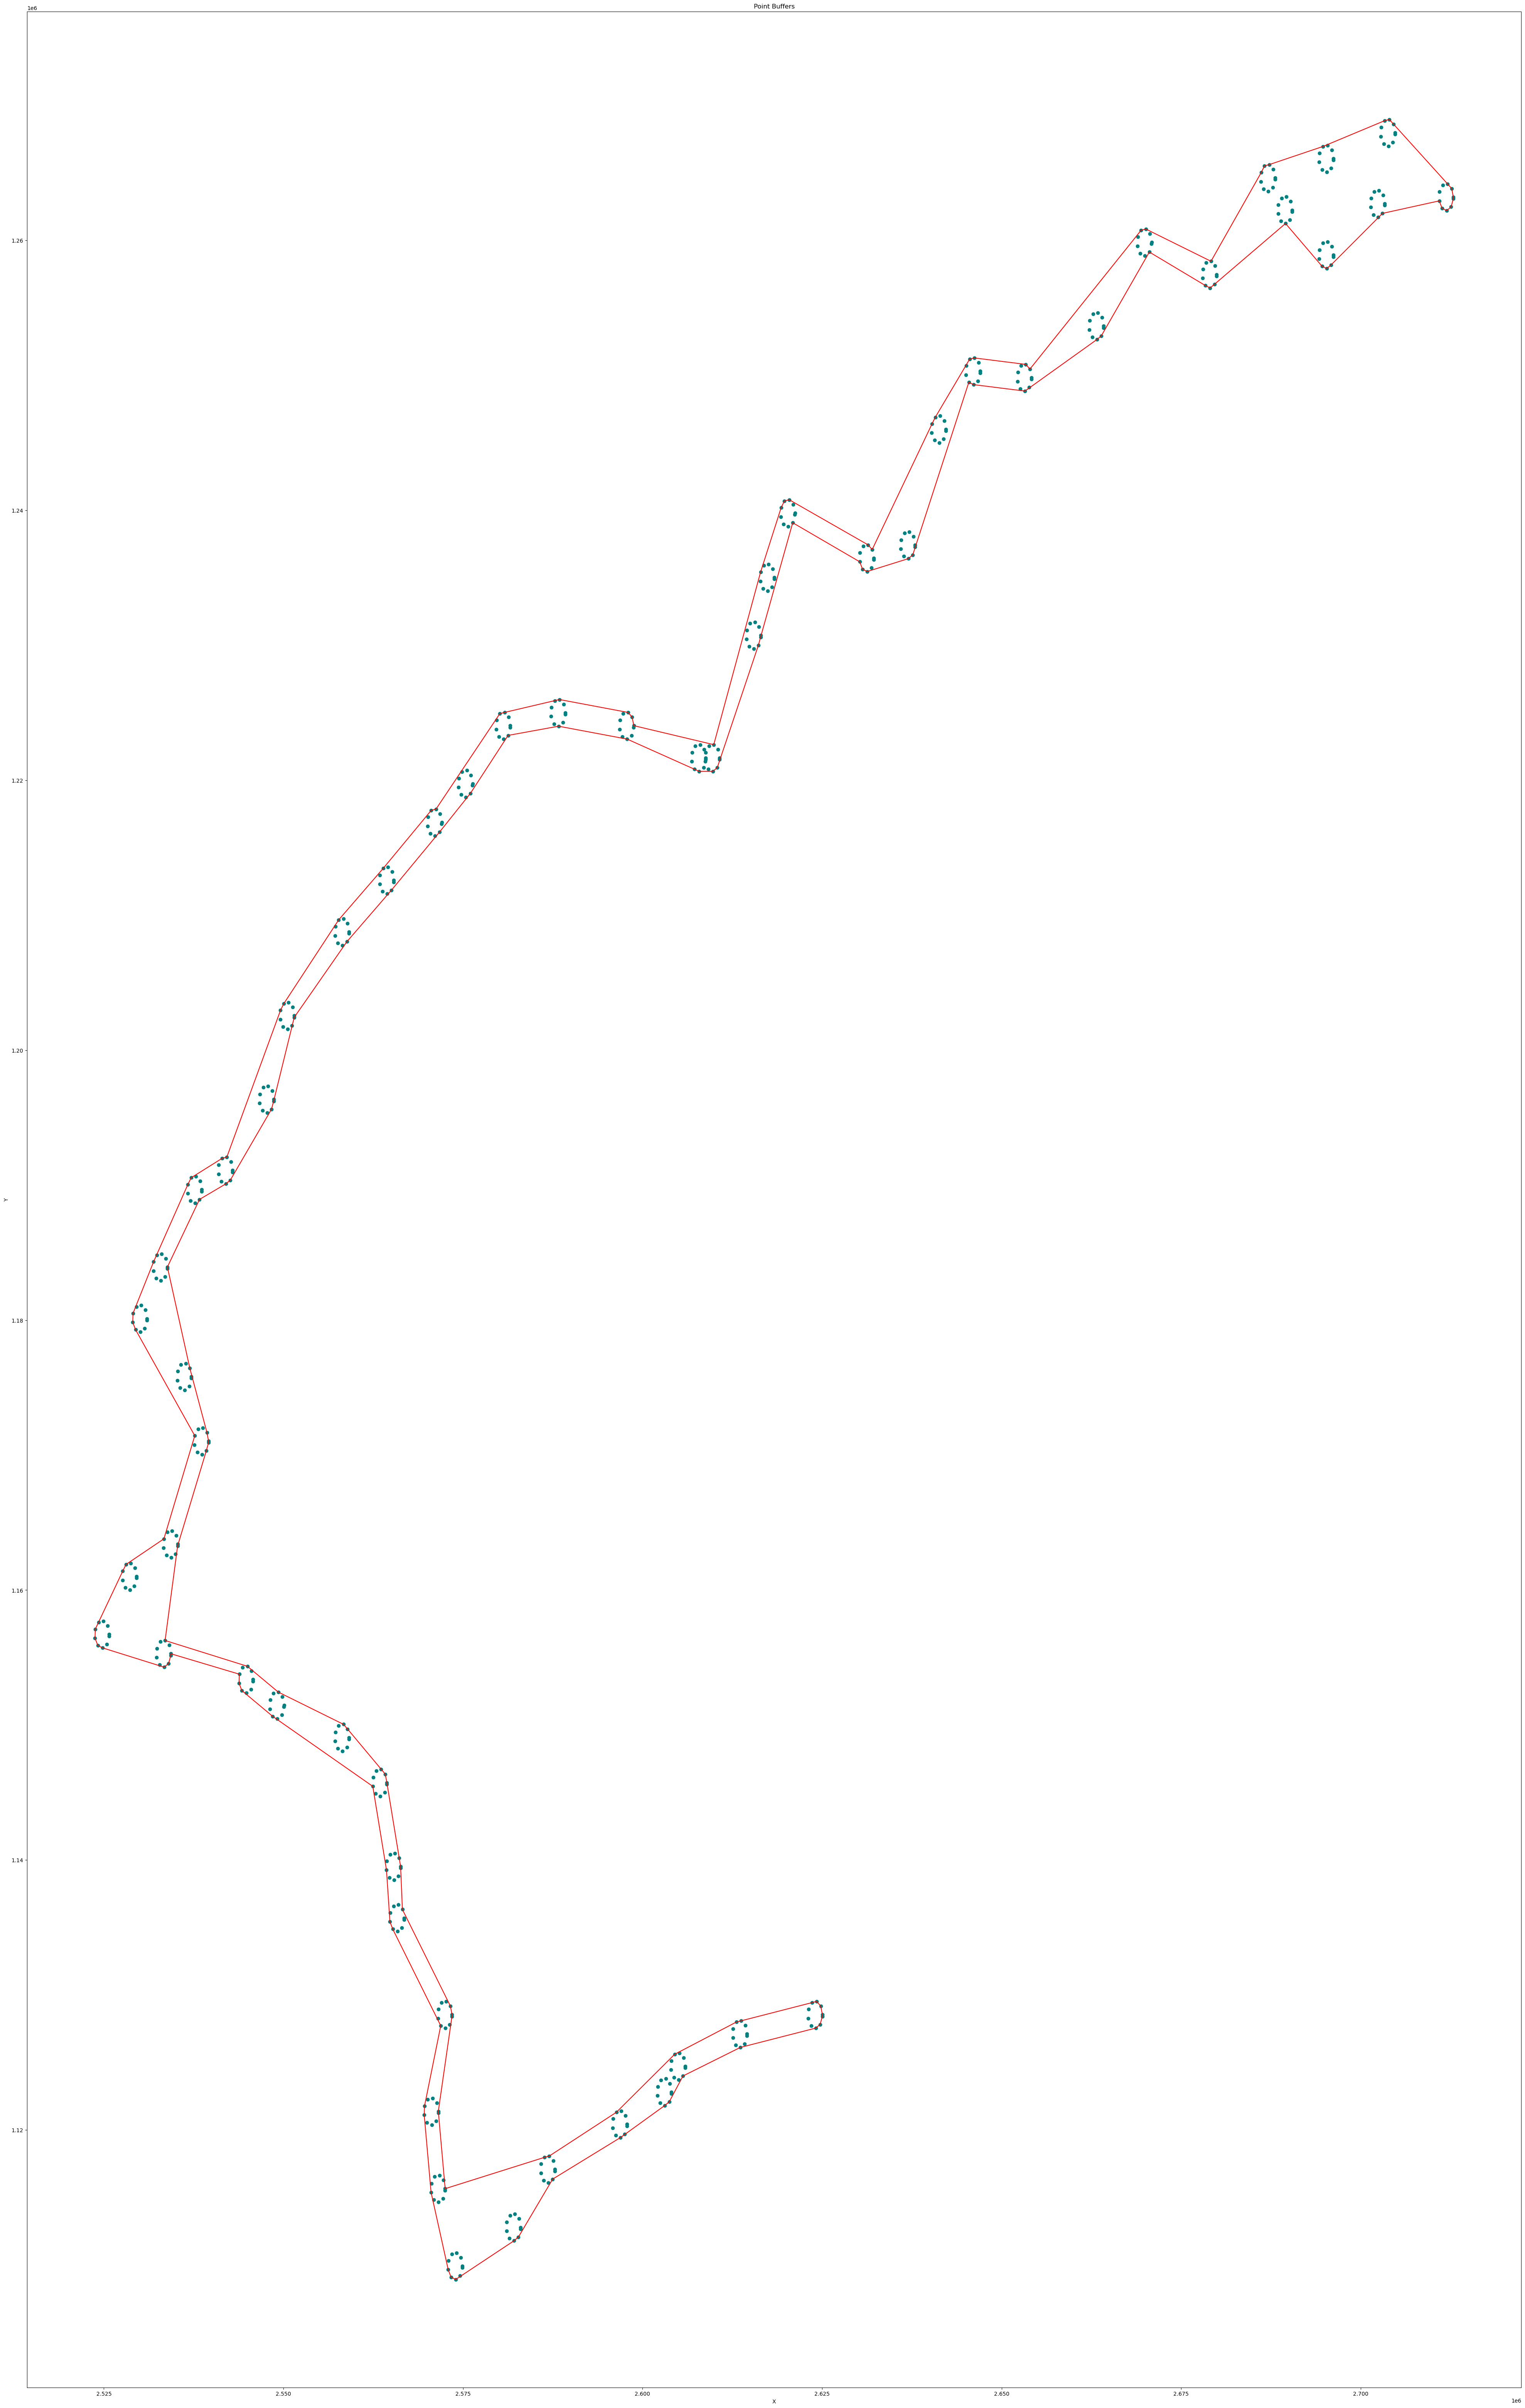

In [40]:
fig, ax0 = plt.subplots(figsize = (50, 80))

ax0.scatter(xs, ys, color='teal')
ax0.plot(hull[:, 0], hull[:, 1], color = 'red')

ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.set_title('Point Buffers')


In [41]:
print(hull[0][0])

2573982.336028127


In [42]:
poly = shapely.Polygon(hull)

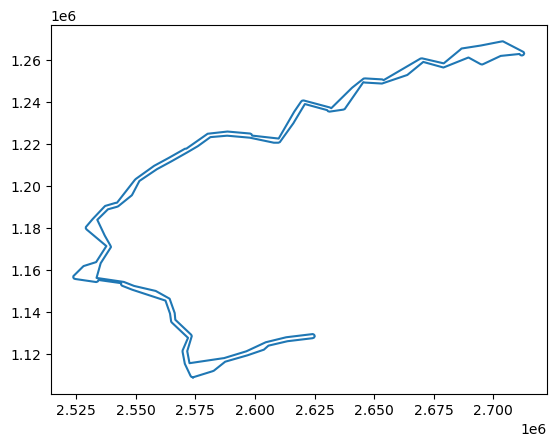

In [43]:
x, y = poly.exterior.xy
plt.plot(x, y)

In [45]:
import shapely
shapely.is_valid(poly)

True